# Importacion Librerias

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Paleta colores para gr√°ficos
color_azul_claro = "#4A90E2"
color_azul_oscuro = "#1F4E79"

## Carga Propensity_clean_v5.csv

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")
file_name = "Propensity_clean_v5.csv"  
file_path = os.path.join(DATA_DIR, file_name)

df_5 = pd.read_csv(file_path)

# Carga Modelo Final

In [4]:
model_path = os.path.join(BASE_DIR, "data", "models_results", "results_v2.csv")
results_df_2 = pd.read_csv(model_path)
bmodel = results_df_2.loc[0]

In [5]:
bmodel

n_estimators             500
learning_rate            0.1
max_depth                  8
min_child_weight           3
gamma                    0.3
subsample                0.9
colsample_bytree         0.7
lambda                     1
alpha                      0
accuracy            0.875883
f1_score            0.875045
recall              0.875883
roc_auc             0.949423
cv_score            0.946107
train_score         0.973987
overfitting               OK
Name: 0, dtype: object

In [6]:
best_params = {
    'n_estimators': int(bmodel['n_estimators']),
    'learning_rate': float(bmodel['learning_rate']),
    'max_depth': int(bmodel['max_depth']),
    'min_child_weight': int(bmodel['min_child_weight']),
    'gamma': float(bmodel['gamma']),
    'subsample': float(bmodel['subsample']),
    'colsample_bytree': float(bmodel['colsample_bytree']),
    'reg_lambda': float(bmodel['lambda']),
    'reg_alpha': float(bmodel['alpha']),
}


best_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    **best_params
)

In [7]:
df_5 = df_5.drop(columns=["Tiempo"], errors="ignore")
y = df_5["Mas_1_coche"]
X = df_5.drop(columns=["Mas_1_coche"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
import joblib

# Guardar el modelo entrenado
joblib.dump(best_model, "modelo_xgboost.pkl")

['modelo_xgboost.pkl']

# Carga Prediciones

In [10]:

results_path = os.path.join(BASE_DIR, "data", "pred_results", "Propensity_Predictions_v2.csv")
pred = pd.read_csv(results_path)

In [11]:
pred.head()

PRODUCTO  TIPO_CARROCERIA  COMBUSTIBLE  Potencia  TRANS  FORMA_PAGO  \
0         0                0            0         0      1           3   
1         0                0            0         0      1           3   
2         0                0            0         0      1           0   
3         0                0            0         0      1           0   
4         0                0            0         0      1           3   

   ESTADO_CIVIL  GENERO  OcupaciOn  PROVINCIA  ...  Zona_Renta  REV_Garantia  \
0             0       1          1         26  ...           2             0   
1             3       1          1         38  ...           0             1   
2             3       0          1         46  ...           3             0   
3             0       0          1         47  ...           0             1   
4             0       0          1          8  ...           3             0   

   Averia_grave  QUEJA_CAC  COSTE_VENTA  km_anno  Revisiones  Edad_Cliente  \
0             0          0         2892        0           1            20   
1             1          0         2892    17967           1            55   
2             2          0         1376        0           1            18   
3             0          0         2594     6219           1            37   
4             3          1         1376        0           1            21   

   Prediccion  Probabilidad_Compra  
0           1             0.986447  
1           1             0.859687  
2           0             0.010904  
3           1             0.529952  
4           0             0.060663  

[5 rows x 23 columns]

# Gr√°ficos Exploratorios

## Distrbucci√≥n de la Probilidad Compra

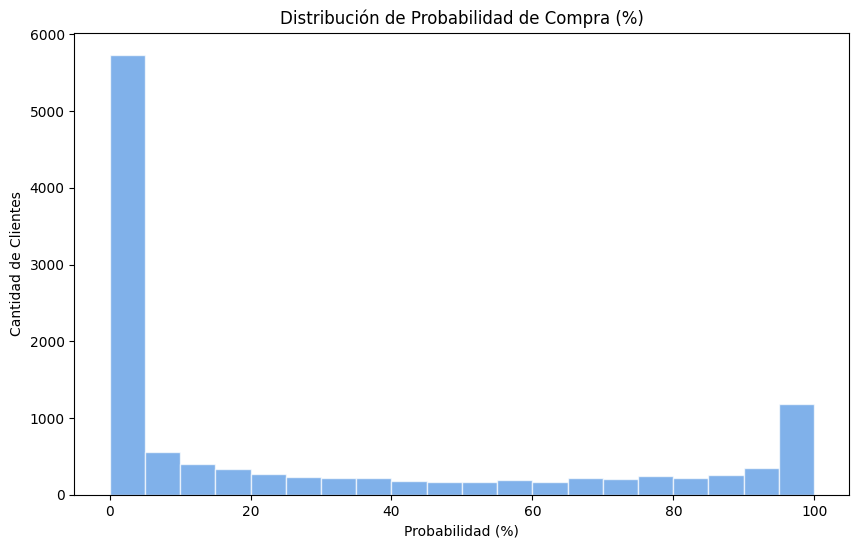

In [12]:
# tranformaci√≥n a porcentaje de la colunmna Probabilidad Compra
pred['porcentaje'] = pred['Probabilidad_Compra'] * 100

#Histograma de la Distribuci√≥n de Probabilidad de Compra
plt.figure(figsize=(10,6))
plt.hist(pred['porcentaje'], bins=20, edgecolor='white', alpha=0.7, color=color_azul_claro)
plt.title('Distribuci√≥n de Probabilidad de Compra (%)')
plt.xlabel('Probabilidad (%)')
plt.ylabel('Cantidad de Clientes')
plt.show()


In [13]:
# Calcular estad√≠sticas clave de la probabilidad de compra
print("M√≠nimo:", pred["Probabilidad_Compra"].min())
print("Media:", pred["Probabilidad_Compra"].mean())
print("M√°ximo:", pred["Probabilidad_Compra"].max())
print("Desviaci√≥n Est√°ndar:", pred["Probabilidad_Compra"].std())

M√≠nimo: 7.1982718e-06
Media: 0.28621782578798566
M√°ximo: 0.9998666
Desviaci√≥n Est√°ndar: 0.36605579154357964


## Gr√°fico Predicci√≥n

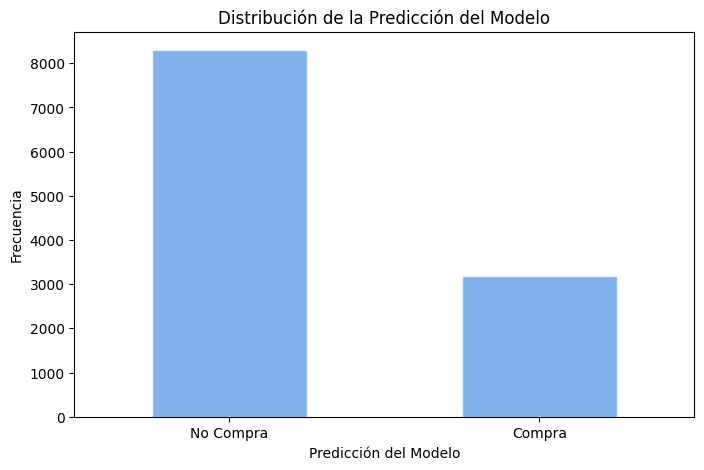

In [14]:
plt.figure(figsize=(8, 5))
ax = pred["Prediccion"].value_counts().sort_index().plot(kind="bar", color=color_azul_claro, edgecolor="white",alpha=0.7)


plt.xticks(ticks=[0, 1], labels=["No Compra", "Compra"], rotation=0)


plt.xlabel("Predicci√≥n del Modelo")
plt.ylabel("Frecuencia")
plt.title("Distribuci√≥n de la Predicci√≥n del Modelo")
plt.show()

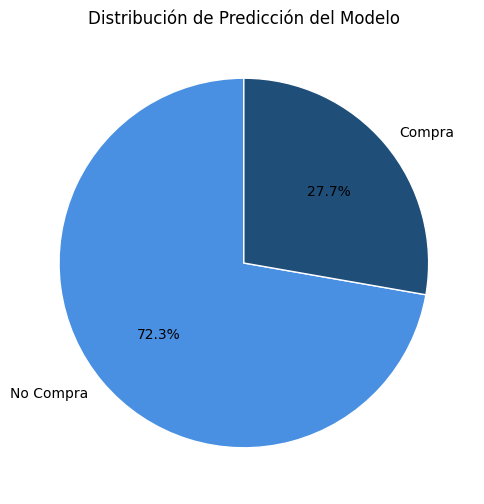

In [15]:
#grafico % de prediccion
plt.figure(figsize=(6, 6))
plt.pie(pred["Prediccion"].value_counts(normalize=True), labels=["No Compra", "Compra"], autopct="%1.1f%%", colors=[color_azul_claro, color_azul_oscuro], startangle=90, wedgeprops={"edgecolor": "white"})
plt.title("Distribuci√≥n de Predicci√≥n del Modelo")


plt.show()

# Feature Importance Global

In [16]:
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

feature_importance_df

Feature  Importance
13       Zona_Renta    0.295625
12        Campanna3    0.100017
0          PRODUCTO    0.091894
5        FORMA_PAGO    0.067836
17      COSTE_VENTA    0.058013
10        Campanna1    0.044228
16        QUEJA_CAC    0.037163
18          km_anno    0.031380
1   TIPO_CARROCERIA    0.030169
15     Averia_grave    0.028583
3          Potencia    0.025787
19       Revisiones    0.025599
2       COMBUSTIBLE    0.023678
9         PROVINCIA    0.022055
11        Campanna2    0.018792
14     REV_Garantia    0.017793
6      ESTADO_CIVIL    0.017477
8         OcupaciOn    0.017288
4             TRANS    0.015880
20     Edad_Cliente    0.015823
7            GENERO    0.014919

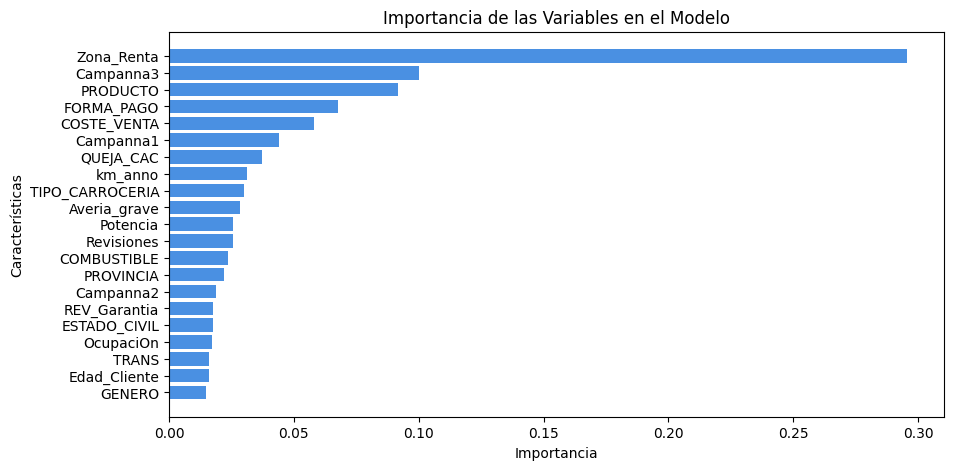

In [17]:
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color=color_azul_claro)
plt.xlabel("Importancia")
plt.ylabel("Caracter√≠sticas")
plt.title("Importancia de las Variables en el Modelo")
plt.gca().invert_yaxis() 
plt.show()

# Segmentacion de los clientes

Los segmentos est√°n definidos de la siguiente manera:

| **Segmento**                 | **Probabilidad de Compra** | **Descripci√≥n** |
|------------------------------|--------------------------|----------------|
| **Clientes Premium**         | 80% - 100%               | Son los clientes con mayor probabilidad de compra. Seguramente ya han interactuado con la marca, han mostrado inter√©s o tienen un historial de compras. |
| **Clientes Potenciales**     | 50% - 80%                | Tienen una buena probabilidad de compra, pero puede que necesiten un empuj√≥n final, como descuentos o incentivos, para concretar la compra. |
| **Clientes Dudosos**         | 30% - 50%                | No est√°n seguros de comprar. Pueden necesitar m√°s informaci√≥n, comparaciones con la competencia o testimonios de otros clientes. |
| **Clientes No Interesados**  | 0% - 30%                 | Son clientes con baja probabilidad de compra. Puede que no est√©n en el momento adecuado para comprar o simplemente no tengan inter√©s en el producto. |


In [18]:
probability_column = "Probabilidad_Compra" if "Probabilidad_Compra" in pred.columns else pred.columns[-1]
print(f"Usando la columna de probabilidad: {probability_column}")

def categorizar_cliente(probabilidad):
    if probabilidad >= 0.8:
        return "Premium"
    elif 0.5 <= probabilidad < 0.8:
        return "Potenciales"
    elif 0.3 <= probabilidad < 0.5:
        return "Dudosos"
    else:
        return "No Interesados"


pred["Tipo_Cliente"] = pred[probability_column].apply(categorizar_cliente)

# Contar cu√°ntos clientes hay en cada segmento
segment_counts = pred["Tipo_Cliente"].value_counts()
print(segment_counts)

Usando la columna de probabilidad: Probabilidad_Compra
Tipo_Cliente
No Interesados    7537
Premium           2006
Potenciales       1181
Dudosos            761
Name: count, dtype: int64


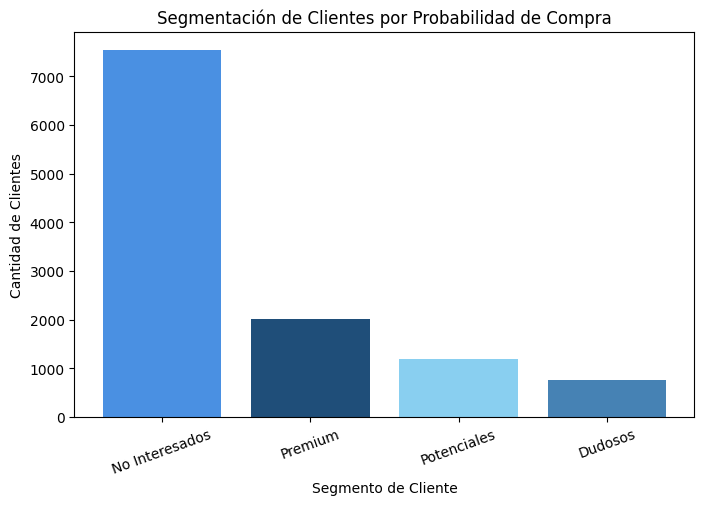

In [19]:
plt.figure(figsize=(8, 5))
plt.bar(segment_counts.index, segment_counts.values, color=['#4A90E2', '#1F4E79', '#89CFF0', '#4682B4'])
plt.xlabel("Segmento de Cliente")
plt.ylabel("Cantidad de Clientes")
plt.title("Segmentaci√≥n de Clientes por Probabilidad de Compra")
plt.xticks(rotation=20)
plt.show()

In [20]:
df_analisis = pred.drop(columns=["Probabilidad_Compra", "Prediccion", "porcentaje"]).copy()
df_analisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11485 entries, 0 to 11484
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PRODUCTO         11485 non-null  int64 
 1   TIPO_CARROCERIA  11485 non-null  int64 
 2   COMBUSTIBLE      11485 non-null  int64 
 3   Potencia         11485 non-null  int64 
 4   TRANS            11485 non-null  int64 
 5   FORMA_PAGO       11485 non-null  int64 
 6   ESTADO_CIVIL     11485 non-null  int64 
 7   GENERO           11485 non-null  int64 
 8   OcupaciOn        11485 non-null  int64 
 9   PROVINCIA        11485 non-null  int64 
 10  Campanna1        11485 non-null  int64 
 11  Campanna2        11485 non-null  int64 
 12  Campanna3        11485 non-null  int64 
 13  Zona_Renta       11485 non-null  int64 
 14  REV_Garantia     11485 non-null  int64 
 15  Averia_grave     11485 non-null  int64 
 16  QUEJA_CAC        11485 non-null  int64 
 17  COSTE_VENTA      11485 non-null

## Comparativa de los grupos

### Variable Num√©ricas

En esta secci√≥n vamos a comparar la media de las variables n√∫mericas para tipo de perfil de clientes.

In [21]:
medias_tipo_cliente = df_analisis.groupby("Tipo_Cliente")[["COSTE_VENTA", "km_anno", "Revisiones", "Edad_Cliente"]].mean()
orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]
medias_tipo_cliente = medias_tipo_cliente.reindex(orden_tipo_cliente)

print("\n Comparaci√≥n de variables num√©ricas por tipo de cliente \n")
display(medias_tipo_cliente)


 Comparaci√≥n de variables num√©ricas por tipo de cliente 



COSTE_VENTA       km_anno  Revisiones  Edad_Cliente
Tipo_Cliente                                                       
No Interesados  2289.448322  10733.643359    3.480165     47.243598
Dudosos         2470.802891  12246.578187    3.816032     47.834428
Potenciales     2591.881456  12166.459780    3.893311     47.447925
Premium         3595.759721  15379.604187    3.251745     47.180957

Conclusiones
- **Premium** ‚Üí Mayor gasto y m√°s kil√≥metros, pero menos revisiones.
- **Potenciales & Dudosos** ‚Üí Gasto similar (Potenciales m√°s que Dudoso), revisan m√°s el coche (~3.8) y recorren menos km que Premium.
- **No Interesados** ‚Üí Menor gasto  y menos kil√≥metros anuales.
- **Edad similar** en todos los grupos (~47 a√±os).

## Variables Categ√≥ricas

En esta secci√≥n vamos a comparar la frecuencia relativa de las variables categ√≥ricas para cada tipo de cliente

In [22]:

variables_numericas = ["COSTE_VENTA", "km_anno", "Revisiones", "Edad_Cliente"]  
variables_categoricas = [col for col in df_analisis.columns if col not in variables_numericas + ["Tipo_Cliente"]]


orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]

print("\n Distribuci√≥n de frecuencias para variables categ√≥ricas ")
for var in variables_categoricas:
    print(f"\nFrecuencia relativa de {var} por tipo de cliente:")
    
    # Agrupar por Tipo_Cliente y contar las frecuencias relativas
    tabla_frecuencia = df_analisis.groupby("Tipo_Cliente")[var].value_counts(normalize=True).unstack().reset_index()
    tabla_frecuencia = tabla_frecuencia.set_index("Tipo_Cliente").reindex(orden_tipo_cliente).reset_index()
    

    display(tabla_frecuencia)


 Distribuci√≥n de frecuencias para variables categ√≥ricas 

Frecuencia relativa de PRODUCTO por tipo de cliente:


PRODUCTO    Tipo_Cliente         0         1         2         3         4  \
0         No Interesados  0.122197  0.284331  0.080403  0.113042  0.008226   
1                Dudosos  0.128778  0.294350  0.089356  0.170828  0.006570   
2            Potenciales  0.168501  0.318374  0.071126  0.160034  0.009314   
3                Premium  0.094217  0.194417  0.046859  0.336989  0.026919   

PRODUCTO         5         6         7         8         9        10  
0         0.000663  0.000398  0.061696  0.276768  0.050816  0.001459  
1              NaN       NaN  0.022339  0.231275  0.053876  0.002628  
2              NaN       NaN  0.019475  0.209992  0.042337  0.000847  
3         0.001496  0.000499  0.049850  0.228315  0.018445  0.001994


Frecuencia relativa de TIPO_CARROCERIA por tipo de cliente:


TIPO_CARROCERIA    Tipo_Cliente         0         1         2         3  \
0                No Interesados  0.380125  0.008226  0.000663  0.080403   
1                       Dudosos  0.454665  0.006570       NaN  0.089356   
2                   Potenciales  0.472481  0.009314       NaN  0.071126   
3                       Premium  0.401296  0.026919  0.001496  0.046859   

TIPO_CARROCERIA         4         5         6         7  
0                0.000398  0.120207  0.390739  0.019238  
1                     NaN  0.111695  0.310118  0.027595  
2                     NaN  0.148180  0.272650  0.026249  
3                0.000499  0.153041  0.298604  0.071286


Frecuencia relativa de COMBUSTIBLE por tipo de cliente:


COMBUSTIBLE    Tipo_Cliente         0         1
0            No Interesados  0.415417  0.584583
1                   Dudosos  0.432326  0.567674
2               Potenciales  0.497036  0.502964
3                   Premium  0.445663  0.554337


Frecuencia relativa de Potencia por tipo de cliente:


Potencia    Tipo_Cliente         0         1         2
0         No Interesados  0.126443  0.690726  0.182831
1                Dudosos  0.135348  0.675427  0.189225
2            Potenciales  0.176969  0.651143  0.171888
3                Premium  0.097707  0.693420  0.208873


Frecuencia relativa de TRANS por tipo de cliente:


TRANS    Tipo_Cliente         0         1
0      No Interesados  0.084384  0.915616
1             Dudosos  0.085414  0.914586
2         Potenciales  0.081287  0.918713
3             Premium  0.097208  0.902792


Frecuencia relativa de FORMA_PAGO por tipo de cliente:


FORMA_PAGO    Tipo_Cliente         0         1         2         3
0           No Interesados  0.515059  0.030383  0.276503  0.178055
1                  Dudosos  0.592641  0.043364  0.206307  0.157687
2              Potenciales  0.573243  0.032176  0.207451  0.187130
3                  Premium  0.494516  0.037388  0.271685  0.196411


Frecuencia relativa de ESTADO_CIVIL por tipo de cliente:


ESTADO_CIVIL    Tipo_Cliente         0         1         2         3
0             No Interesados  0.762372  0.022157  0.016452  0.199018
1                    Dudosos  0.805519  0.019711  0.017083  0.157687
2                Potenciales  0.771380  0.022015  0.015241  0.191363
3                    Premium  0.782154  0.026919  0.016451  0.174477


Frecuencia relativa de GENERO por tipo de cliente:


GENERO    Tipo_Cliente         0         1
0       No Interesados  0.295608  0.704392
1              Dudosos  0.296978  0.703022
2          Potenciales  0.317528  0.682472
3              Premium  0.244267  0.755733


Frecuencia relativa de OcupaciOn por tipo de cliente:


OcupaciOn    Tipo_Cliente         0         1         2
0          No Interesados  0.024811  0.923046  0.052143
1                 Dudosos  0.019711  0.926413  0.053876
2             Potenciales  0.023709  0.911939  0.064352
3                 Premium  0.033898  0.904786  0.061316


Frecuencia relativa de PROVINCIA por tipo de cliente:


PROVINCIA    Tipo_Cliente         0         1         2         3         4  \
0          No Interesados  0.018442  0.009155  0.041661  0.010349  0.020167   
1                 Dudosos  0.007884  0.001314  0.027595  0.003942  0.030223   
2             Potenciales  0.007621  0.007621  0.030483  0.009314  0.015241   
3                 Premium  0.009472  0.005982  0.035892  0.008973  0.011964   

PROVINCIA         5         6         7         8  ...        42        43  \
0          0.002123  0.009288  0.018442  0.126310  ...  0.024811  0.000265   
1               NaN  0.005256  0.011827  0.207622  ...  0.021025       NaN   
2          0.001693  0.009314  0.013548  0.206605  ...  0.025402  0.001693   
3          0.000997  0.006979  0.018943  0.160518  ...  0.018943       NaN   

PROVINCIA        44        45        46        47        48        49  \
0          0.022157  0.004113  0.013666  0.046570  0.009818  0.029720   
1          0.026281  0.003942  0.010512  0.036794  0.009198  0.036794   
2          0.012701       NaN  0.009314  0.034716  0.009314  0.025402   
3          0.014955  0.002991  0.017946  0.028415  0.009970  0.023928   

PROVINCIA        50        51  
0          0.002123  0.024944  
1               NaN  0.019711  
2          0.000847  0.020322  
3          0.001994  0.018943  

[4 rows x 53 columns]


Frecuencia relativa de Campanna1 por tipo de cliente:


Campanna1    Tipo_Cliente         0         1
0          No Interesados  0.687939  0.312061
1                 Dudosos  0.676741  0.323259
2             Potenciales  0.668078  0.331922
3                 Premium  0.463609  0.536391


Frecuencia relativa de Campanna2 por tipo de cliente:


Campanna2    Tipo_Cliente         0         1
0          No Interesados  0.881783  0.118217
1                 Dudosos  0.862024  0.137976
2             Potenciales  0.859441  0.140559
3                 Premium  0.897308  0.102692


Frecuencia relativa de Campanna3 por tipo de cliente:


Campanna3    Tipo_Cliente         0         1
0          No Interesados  0.867056  0.132944
1                 Dudosos  0.969777  0.030223
2             Potenciales  0.964437  0.035563
3                 Premium  0.848953  0.151047


Frecuencia relativa de Zona_Renta por tipo de cliente:


Zona_Renta    Tipo_Cliente         0         1         2         3         4
0           No Interesados  0.129494  0.294812  0.245190  0.308345  0.022157
1                  Dudosos  0.731932  0.034166  0.206307  0.022339  0.005256
2              Potenciales  0.705334  0.051651  0.205758  0.029636  0.007621
3                  Premium  0.533400  0.148554  0.203888  0.100698  0.013460


Frecuencia relativa de REV_Garantia por tipo de cliente:


REV_Garantia    Tipo_Cliente         0         1
0             No Interesados  0.567865  0.432135
1                    Dudosos  0.541393  0.458607
2                Potenciales  0.504657  0.495343
3                    Premium  0.482054  0.517946


Frecuencia relativa de Averia_grave por tipo de cliente:


Averia_grave    Tipo_Cliente         0         1         2         3
0             No Interesados  0.501791  0.065543  0.114634  0.318031
1                    Dudosos  0.500657  0.082786  0.131406  0.285151
2                Potenciales  0.559695  0.077053  0.145639  0.217612
3                    Premium  0.538385  0.085743  0.137587  0.238285


Frecuencia relativa de QUEJA_CAC por tipo de cliente:


QUEJA_CAC    Tipo_Cliente         0         1
0          No Interesados  0.599045  0.400955
1                 Dudosos  0.607096  0.392904
2             Potenciales  0.680779  0.319221
3                 Premium  0.677966  0.322034

In [23]:

variables_numericas = ["COSTE_VENTA", "km_anno", "Revisiones", "Edad_Cliente"]
variables_categoricas = [col for col in df_analisis.columns if col not in variables_numericas + ["Tipo_Cliente"]]

## Perfil Clientes

## Producto

In [24]:
orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]
variable_a_analizar = "PRODUCTO"  

print(f"\nFrecuencia relativa de {variable_a_analizar} por tipo de cliente:")

tabla_frecuencia = df_analisis.groupby("Tipo_Cliente")[variable_a_analizar].value_counts(normalize=True).unstack().reset_index()

tabla_frecuencia = tabla_frecuencia.set_index("Tipo_Cliente").reindex(orden_tipo_cliente).reset_index()
display(tabla_frecuencia)


Frecuencia relativa de PRODUCTO por tipo de cliente:


PRODUCTO    Tipo_Cliente         0         1         2         3         4  \
0         No Interesados  0.122197  0.284331  0.080403  0.113042  0.008226   
1                Dudosos  0.128778  0.294350  0.089356  0.170828  0.006570   
2            Potenciales  0.168501  0.318374  0.071126  0.160034  0.009314   
3                Premium  0.094217  0.194417  0.046859  0.336989  0.026919   

PRODUCTO         5         6         7         8         9        10  
0         0.000663  0.000398  0.061696  0.276768  0.050816  0.001459  
1              NaN       NaN  0.022339  0.231275  0.053876  0.002628  
2              NaN       NaN  0.019475  0.209992  0.042337  0.000847  
3         0.001496  0.000499  0.049850  0.228315  0.018445  0.001994

In [25]:
variable_categorica = "PRODUCTO"  

# Orden para los tipos de clientes
orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]
for tipo_cliente in orden_tipo_cliente:
    
    df_filtrado = df_analisis[df_analisis["Tipo_Cliente"] == tipo_cliente]
    top3_productos = df_filtrado[variable_categorica].value_counts(normalize=True).head(3) * 100

    top3_productos = top3_productos.reset_index()
    top3_productos.columns = [variable_categorica, "Frecuencia (%)"]
    
    # Mostrar t√≠tulo y tabla espec√≠fica para cada tipo de cliente
    print(f"\nTop 3 productos m√°s comprados por '{tipo_cliente}':")
    display(top3_productos)


Top 3 productos m√°s comprados por 'No Interesados':


PRODUCTO  Frecuencia (%)
0         1       28.433064
1         8       27.676794
2         0       12.219716


Top 3 productos m√°s comprados por 'Dudosos':


PRODUCTO  Frecuencia (%)
0         1       29.434954
1         8       23.127464
2         3       17.082786


Top 3 productos m√°s comprados por 'Potenciales':


PRODUCTO  Frecuencia (%)
0         1       31.837426
1         8       20.999153
2         0       16.850127


Top 3 productos m√°s comprados por 'Premium':


PRODUCTO  Frecuencia (%)
0         3       33.698903
1         8       22.831505
2         1       19.441675

## üìä **Patrones Identificados**
1. **El Producto 1 domina en los tres primeros segmentos**, pero pierde relevancia en clientes Premium.
2. **El Producto 3 es el m√°s comprado por los clientes Premium (33.69%)**, lo que sugiere que es un producto de gama alta.
3. **El Producto 8 es consistente en todos los segmentos**, lo que indica que tiene buena aceptaci√≥n general.
4. **El Producto 0 es clave para No Interesados y Potenciales**, pero no es relevante para Premium.



## üéØ **Recomendaciones Estrat√©gicas**
‚úÖ **Para atraer a No Interesados y Dudosos**, reforzar campa√±as promocionales del **Producto 1**.  
‚úÖ **Para convertir Potenciales en Premium**, destacar los beneficios exclusivos del **Producto 3**.  
‚úÖ **Para los Premium**, centrar la estrategia en el **Producto 3** y su valor diferencial.  
‚úÖ **Si se busca un producto vers√°til, el Producto 8** puede ser una buena opci√≥n para todos los segmentos.  

## Potencia

## üìä **Patrones Identificados en Potencia por Tipo de Cliente**
- **La mayor√≠a de los clientes prefieren Potencia Media (~65-70%)**, lo que indica que no es un factor clave de diferenciaci√≥n.  
- **Los Premium tienen mayor inclinaci√≥n por Potencia Alta (20.88%)**, mientras que los No Interesados presentan el menor porcentaje (18.28%).  
- **Los No Interesados tienen mayor presencia en Potencia Baja (12.64%)**, lo que sugiere que buscan opciones m√°s econ√≥micas.  
- **Los Potenciales tienen una distribuci√≥n m√°s balanceada**, sin una preferencia clara por un nivel de potencia espec√≠fico.  



## üéØ **Recomendaciones Estrat√©gicas**
‚úÖ **Para convertir Potenciales en Premium**, resaltar modelos de **Potencia Alta**, ya que es donde m√°s se diferencian.  
‚úÖ **Para atraer a No Interesados**, enfocar estrategias en **modelos de Potencia Media y Baja** con buena relaci√≥n calidad-precio. 

## Genero 

## üìä **Patrones Identificados en G√âNERO**
- La mayor√≠a de los clientes pertenecen al grupo **1 (~70-75%)**, con una mayor concentraci√≥n en **Premium (75.57%)**.    
- **El grupo 0 (posiblemente Femenino) tiene menor presencia en todos los segmentos**, siendo m√°s bajo en Premium (24.43%).  

## üéØ **Recomendaciones Estrat√©gicas**
‚úÖ **Los clientes Premium est√°n dominados por el grupo 1**, lo que sugiere que es el perfil m√°s propenso a realizar compras.   
‚úÖ **Si se busca mayor equilibrio, explorar estrategias para atraer m√°s clientes del grupo 0.**  

## Campa√±a 1

## üìä **Patrones Identificados en Campa√±a 1 (Descuento por Financiar)**
- **La mayor√≠a de No Interesados, Dudosos y Potenciales no aprovechan el descuento (~67-69%)**.  
- **En Premium, m√°s de la mitad (53.64%) s√≠ utilizan la campa√±a**, lo que indica que valoran el beneficio de financiar.  
- **A medida que el cliente avanza en el inter√©s de compra, aumenta la proporci√≥n de quienes aprovechan el descuento**.  


## üéØ **Recomendaciones Estrat√©gicas**
‚úÖ **El descuento por financiar es m√°s atractivo para clientes Premium.**  
‚úÖ **Para convertir Potenciales en Premium, resaltar este beneficio en la estrategia comercial.**  
‚úÖ **Para atraer a No Interesados y Dudosos, mejorar la comunicaci√≥n del descuento o explorar otros incentivos.**  

## Campa√±a 2

## üìä **Patrones Identificados en Campa√±a 2 (Descuento por Adquirir un Seguro)**
- **La mayor√≠a de los clientes no aprovechan el descuento (~86-89%) en todos los segmentos**.  
- **Los Premium son los que menos lo utilizan (10.27%)**, lo que indica que este incentivo no es relevante para ellos.  
- **Los Potenciales y Dudosos lo aprovechan en mayor medida (~14%), aunque la diferencia no es significativa**.  

## üéØ **Recomendaciones Estrat√©gicas**
‚úÖ **Dado el bajo impacto de esta campa√±a, podr√≠a ser m√°s eficiente eliminarla y redirigir la inversi√≥n a otros incentivos m√°s atractivos.**  
‚úÖ **Explorar qu√© beneficios valoran m√°s los clientes (ej. descuentos directos en el veh√≠culo o financiamiento flexible).**  
‚úÖ **Si se mantiene, reformular la oferta para hacerla m√°s atractiva, por ejemplo, incluyendo seguros con coberturas adicionales o mayor flexibilidad.**  

## Campa√±a 3

## üìä **Patrones Identificados en Campa√±a 3**
- **La mayor√≠a de los clientes no aprovechan esta campa√±a (~85-97%)**, con menor uso en Dudosos (3.02%) y Potenciales (3.55%).  
- **Los Premium la utilizan un poco m√°s (15.10%)**, aunque sigue siendo una minor√≠a.  
- **Dudosos y Potenciales pr√°cticamente no la consideran, lo que sugiere que no es un incentivo relevante para estos segmentos.**  



## üéØ **Recomendaciones Estrat√©gicas**
‚úÖ **La baja adopci√≥n indica que esta campa√±a podr√≠a no ser efectiva y su presupuesto podr√≠a redirigirse a incentivos m√°s atractivos.**  
‚úÖ **Si se mantiene, se deber√≠a analizar qu√© aspectos valoran los Premium para potenciar su impacto en otros segmentos.**  
‚úÖ **Para atraer a No Interesados y Dudosos, se podr√≠an explorar alternativas m√°s alineadas con sus necesidades.**  

## Zona Renta

## üìä **Perfiles de Clientes seg√∫n Zona_Renta**
### üü¢ **Cliente Premium**  
- **Mayor√≠a en Zona 0 (Alto, 53.34%)**, lo que indica que este segmento proviene principalmente de √°reas de alta renta.  
- **Tambi√©n hay presencia en Zona 2 (Medio, 20.38%) y Zona 1 (Desconocido, 14.85%)**, lo que sugiere que algunos Premium tambi√©n provienen de zonas con renta media o sin informaci√≥n clara.  
- **Baja representaci√≥n en Zona 3 (Medio-Bajo, 10.07%) y Zona 4 (Otros, 1.34%)**, por lo que es menos com√∫n que clientes de menor renta lleguen a ser Premium.  



### üü° **Cliente Potencial**  
- **Gran parte se encuentra en Zona 0 (Alto, 70.53%)**, similar a los Premium, lo que indica que muchas personas con intenci√≥n de compra provienen de √°reas de alta renta.  
- **Presencia menor en Zona 2 (Medio, 20.57%)**, lo que sugiere que algunos clientes con intenci√≥n de compra tambi√©n est√°n en √°reas de renta media.  
- **Escasa representaci√≥n en otras zonas, especialmente en Zona 3 (Medio-Bajo, 2.96%) y Zona 4 (Otros, 0.76%)**.  



### üü† **Cliente Dudoso**  
- **Mayor concentraci√≥n en Zona 0 (Alto, 73.19%)**, lo que indica que la mayor√≠a de estos clientes proviene de √°reas de mayor renta, aunque a√∫n no est√°n convencidos de comprar.  
- **Poca representaci√≥n en otras zonas**, con una leve presencia en Zona 2 (Medio, 20.63%).  
- **Las Zonas 3 (Medio-Bajo, 2.23%) y 4 (Otros, 0.52%) apenas tienen clientes en este grupo.**  



### üî¥ **Cliente No Interesado**  
- **Distribuci√≥n m√°s equilibrada en comparaci√≥n con otros segmentos**.  
- **Zona 3 (Medio-Bajo, 30.83%) y Zona 1 (Desconocido, 29.48%) tienen una mayor concentraci√≥n**, lo que indica que estos clientes provienen principalmente de √°reas de menor renta o sin informaci√≥n clara.  
- **Menor presencia en Zona 0 (Alto, 12.95%)**, lo que sugiere que los clientes de renta alta tienen m√°s inter√©s en la compra.  



## üéØ **Conclusiones Generales**
‚úÖ **Los clientes Premium, Potenciales y Dudosos provienen en su mayor√≠a de la Zona 0 (Alto), lo que indica que la renta alta est√° asociada con una mayor propensi√≥n a comprar.**  
‚úÖ **Los No Interesados son los √∫nicos con mayor representaci√≥n en zonas de renta m√°s baja o desconocida (Zonas 3 y 1).**  
‚úÖ **Para aumentar la conversi√≥n de Potenciales a Premium, se podr√≠a analizar qu√© diferencia a estos clientes dentro de la Zona 0.**  
‚úÖ **Si se quiere atraer m√°s clientes Premium desde zonas de renta media o baja, habr√≠a que evaluar qu√© barreras existen en estas √°reas y c√≥mo superarlas.**  

## REV_GARANTIA

## üìä **Patrones Identificados en REV_Garantia (Coche en Garant√≠a)**
- **Los clientes Premium son los √∫nicos donde la mayor√≠a de los veh√≠culos est√°n en garant√≠a (51.79%)**, lo que sugiere que este segmento compra coches m√°s nuevos o con cobertura.  
- **Los Potenciales est√°n m√°s equilibrados (50.46% sin garant√≠a vs. 49.53% con garant√≠a), lo que indica que algunos consideran la garant√≠a un factor importante.**  
- **Los Dudosos y No Interesados tienen una mayor proporci√≥n de coches sin garant√≠a (~54-56%)**, lo que podr√≠a significar que valoran menos este aspecto o tienen coches m√°s antiguos.  



## üéØ **Conclusiones y Estrategias**
‚úÖ **La garant√≠a parece ser un factor relevante para los clientes Premium**, por lo que se puede destacar este beneficio en estrategias de venta.  
‚úÖ **Para convertir Potenciales en Premium, reforzar la importancia de la garant√≠a como elemento diferenciador.**  
‚úÖ **Los No Interesados y Dudosos pueden estar menos preocupados por la garant√≠a, por lo que otros incentivos (financiamiento o descuentos) podr√≠an ser m√°s efectivos para atraerlos.**  

## Averias

## üìä **Patrones Identificados en Aver√≠a Grave**
- **La mayor√≠a de los clientes en todos los segmentos no han experimentado aver√≠as graves (~50-55%).**  
- **Los No Interesados y Dudosos tienen una mayor proporci√≥n de aver√≠as de tipo 2 (graves) y 3 (muy graves)** en comparaci√≥n con Potenciales y Premium.  
- **Los clientes Premium y Potenciales presentan menos aver√≠as graves, lo que podr√≠a estar relacionado con la antig√ºedad y mantenimiento de sus veh√≠culos.**  



## üéØ **Conclusiones y Estrategias**
‚úÖ **Las aver√≠as graves podr√≠an estar frenando la compra en los segmentos de No Interesados y Dudosos**, ya que han experimentado m√°s problemas mec√°nicos.  
‚úÖ **Para mejorar la conversi√≥n de estos clientes, se pueden resaltar garant√≠as extendidas, programas de mantenimiento o beneficios en reparaciones.**  
‚úÖ **Los Premium y Potenciales presentan menos aver√≠as, lo que puede estar asociado a la compra de veh√≠culos m√°s nuevos o mejor mantenidos.**  

## QUEJA CAC

## üìä **Patrones Identificados en QUEJA_CAC (Llamadas al Centro de Atenci√≥n al Cliente)**
- **Los clientes Potenciales (31.92%) y Premium (32.20%) son los que menos han contactado con el centro de atenci√≥n**, lo que sugiere que tienen menos problemas o menos necesidad de asistencia.  
- **Los No Interesados (40.09%) y Dudosos (39.29%) han llamado con mayor frecuencia**, lo que puede indicar que han tenido m√°s dudas, problemas o insatisfacci√≥n con el servicio.  


## üéØ **Conclusiones y Estrategias**
‚úÖ **El contacto con el CAC puede estar relacionado con experiencias negativas o dudas que frenan la compra, especialmente en No Interesados y Dudosos.**  
‚úÖ **Mejorar la comunicaci√≥n y resoluci√≥n de problemas en estos segmentos podr√≠a ayudar a convertir m√°s clientes.**  
‚úÖ **Los Premium y Potenciales requieren menos asistencia, lo que podr√≠a estar asociado con una mejor experiencia de compra o un menor n√∫mero de problemas.**  

## Perfil Comprador no Comprador 

## Variables Num√©ricas

In [26]:
media_variables = pred.groupby("Prediccion")[variables_numericas].mean().reset_index()
media_variables.index = [""] * len(media_variables)


display(media_variables)

Prediccion  COSTE_VENTA       km_anno  Revisiones  Edad_Cliente
           0  2306.080140  10872.392866    3.510966     47.297783
           1  3223.754628  14188.915908    3.489489     47.279887


- Los compradores tienen un mayor coste de venta en comparaci√≥n con los no compradores.  
- Tambi√©n presentan un mayor kilometraje anual, lo que sugiere que los clientes que usan m√°s el coche est√°n m√°s dispuestos a comprar.  
- No hay una diferencia significativa en la cantidad de revisiones entre ambos grupos, por lo que esta variable no parece influir en la decisi√≥n de compra.  